In [1]:
import torch
import numpy as np
import torchvision 
from torchvision import transforms 
import torch.nn as nn

# load mnist

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)


In [2]:
from torch.utils.data import Subset, random_split


mnist_full_train = torchvision.datasets.MNIST(root=image_path,
                                               train=True,
                                               transform=transform,
                                               download=True)

# we only want 5000 for training and 5000 for validation
subset_size = 5000
train_subset, valid_subset, _ = random_split(mnist_full_train, [subset_size, subset_size, len(mnist_full_train) - 2*subset_size])

mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                                train=False,
                                                transform=transform,
                                                download=True)

In [3]:
from torch.utils.data import DataLoader

# construct the data loaders

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_subset, batch_size, shuffle=True)
valid_dl = DataLoader(valid_subset, batch_size, shuffle=False)

In [4]:
import torch.nn.functional as F

# construct cnn class
# padding preserves 28 * 28 image size after convolution
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=50, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(50*7*7, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()
device = torch.device("cpu")
model = model.to(device) 

In [5]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 accuracy: 0.7398 val_accuracy: 0.9134
Epoch 2 accuracy: 0.9406 val_accuracy: 0.9454
Epoch 3 accuracy: 0.9616 val_accuracy: 0.9534
Epoch 4 accuracy: 0.9702 val_accuracy: 0.9640
Epoch 5 accuracy: 0.9836 val_accuracy: 0.9640
Epoch 6 accuracy: 0.9860 val_accuracy: 0.9616
Epoch 7 accuracy: 0.9914 val_accuracy: 0.9636
Epoch 8 accuracy: 0.9930 val_accuracy: 0.9638
Epoch 9 accuracy: 0.9944 val_accuracy: 0.9724
Epoch 10 accuracy: 0.9972 val_accuracy: 0.9710


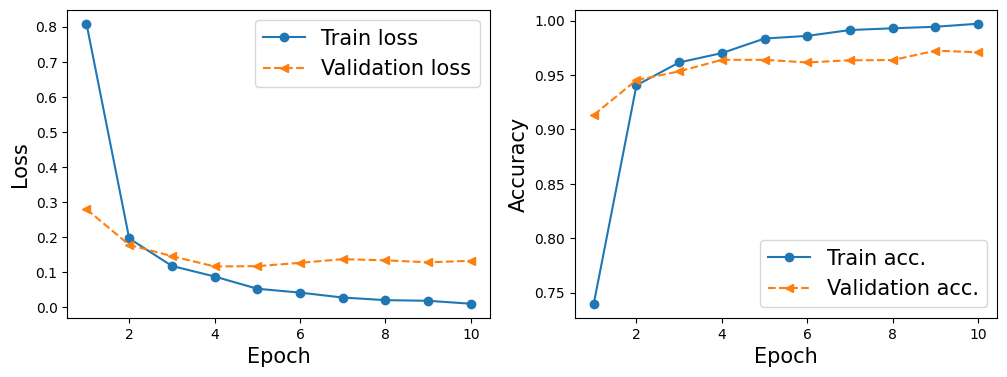

In [6]:
# plot the learning and validation curves
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()


In [7]:
# now find prediction accuracy on the test data

model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9767


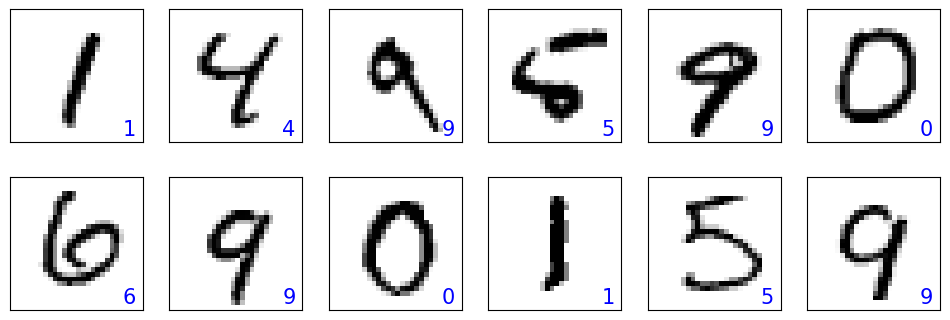

In [8]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i+5][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()